In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(rc={'figure.facecolor':'white'})

## Data loading + munging 

In [2]:
df = pd.read_csv("../data/drugs_2019_20210218.csv")

### Inspect Data Columns

In [3]:
df.columns

Index(['dm_offender_race_ethnicity', 'dm_offender_sex', 'dm_offender_age',
       'offender_seq_num', 'offense_type_id', 'location_id',
       'cleared_except_id', 'arrest_type_id', 'criminal_act_id',
       'relationship_id', 'prop_loss_id', 'prop_desc_id', 'property_value',
       'suspected_drug_type_id', 'est_drug_qty', 'drug_measure_type_id',
       'state_abbr'],
      dtype='object')

- Get Drugs to standard quantity
- Stratify by Drug
- Stratify by state

### Drop NA + Unknown measure type + Unknown offender race

In [4]:
df = df.dropna(subset=['drug_measure_type_id', 'est_drug_qty'], how="any", axis=0)
df = df[df["drug_measure_type_id"] != 11]
df = df[df["dm_offender_race_ethnicity"] != "unknown"]

### Convert drug quantity to uniform measures

In [5]:
quantity_dict = {
    1: 1,
    2: 1000,
    3: 28.3495,
    4: 453.592,
    5: 1,
    6: 1000,
    7: 28.4131,
    8: 3785.41,
    9: 1,
    10: 1,
    11: 1
}
quantity_conv = lambda x: quantity_dict[x["drug_measure_type_id"]] * x["est_drug_qty"]

### Convert numerical columns to strings

In [6]:
drug_types = [
    "Crack Cocaine",
    "Cocaine",
    "Hashish",
    "Heroin",
    "Marijuana",
    "Morphine",
    "Opium",
    "Other Narcotics",
    "LSD",
    "PCP",
    "Other Hallucingens",
    "Meth/ Amphetamines",
    "Other Stimulants",
    "Barbiturates",
    "Other Depressants",
    "Other Drugs",
    "Unknown",
    "More Than 3 Types",
]
drug_type_dict = {i + 1: d for i, d in enumerate(drug_types)}

In [7]:
unit_type = [
    "Gram",
    "Kilogram",
    "Ounce",
    "Pound",
    "Milliliter",
    "Liter",
    "Fluid Ounce",
    "Gallon",
    "Dosage Unit",
    "Number of Plants",
    "Not Reported",
]
unit_type_dict = {i + 1: u for i, u in enumerate(unit_type)}

In [8]:
carry_allowance_2019 = {
    'AR': 0,
    'AZ': 0,
    'CO': 28,
    'CT': 14,
    'DE': 28,
    'GA': 0,
    'HI': 0,
    'IA': 0,
    'ID': 0,
    'IN': 0,
    'KS': 0,
    'KY': 0,
    'LA': 0,
    'MA': 28,
    'MD': 10,
    'ME': 71,
    'MI': 0,
    'MN': 42.5,
    'MO': 10,
    'MS': 30,
    'MT': 0, 
    'NB': 28,
    'NC': 42, 
    'ND': 0,
    'NH': 21,
    'NM': 0,
    'NV': 32,
    'OH': 100,
    'OK': 0,
    'OR': 28,
    'PA': 0,
    'RI': 28,
    'SC': 0,
    'SD': 0,
    'TN': 0,
    'TX': 0,
    'UT': 0,
    'VA': 0,
    'VT': 28,
    'WA': 28,
    'WI': 0,
    'WV': 0,
    'WY': 0
}
drug_state_dict = {
    "Gram": "Mass",
    "Kilogram": "Mass",
    "Ounce": "Mass",
    "Pound": "Mass",
    "Milliliter": "Volume",
    "Liter": "Volume",
    "Fluid Ounce": "Volume",
    "Gallon": "Volume",
    "Dosage Unit": "Unit",
    "Number of Plants": "Unit",
}

In [9]:
df["est_drug_qty_standard"] = df.apply(quantity_conv, axis=1)
df.suspected_drug_type_id = df.suspected_drug_type_id.map(drug_type_dict)
df.drug_measure_type_id = df.drug_measure_type_id.map(unit_type_dict)
df["carry_allowance"] = df.state_abbr.map(carry_allowance_2019)
df["drug_state"] = df.drug_measure_type_id.map(drug_state_dict)

### Quantity Normalization

In [10]:
df["drug_qty_below_limit"] = df.est_drug_qty_standard - df.carry_allowance

### Observe counts of measures given drug type

In [11]:
pd.crosstab([df.suspected_drug_type_id], df.drug_measure_type_id)

drug_measure_type_id,Dosage Unit,Fluid Ounce,Gallon,Gram,Kilogram,Liter,Milliliter,Number of Plants,Ounce,Pound
suspected_drug_type_id,,,,,,,,,,
Barbiturates,6115,5,0,1329,35,0,18,0,93,0
Cocaine,5482,88,124,106053,4092,15,95,0,3443,461
Crack Cocaine,6165,98,139,95241,4692,14,40,0,1390,4
Hashish,2235,452,26,12168,50,0,302,0,650,155
Heroin,31513,1045,263,200763,3089,128,3240,0,5187,281
LSD,6119,23,1,2070,165,0,12,0,282,0
Marijuana,52179,4717,1789,872375,19248,221,2315,6102,122543,12478
Meth/ Amphetamines,58606,2203,1181,650710,3156,24,5598,0,26665,2061
Morphine,3282,36,4,915,1,0,294,0,37,14


### Data Conditions

In [12]:
cannabis_condition = ((df["est_drug_qty_standard"] < 100) & (df["suspected_drug_type_id"] == drug_type_dict[5]) & (df["drug_state"] == "Mass"))

over_21_condition = (df["dm_offender_age"] >= 21)

under_21_condition = (df["dm_offender_age"] < 21)

possesion_condition = (df.criminal_act_id == 6) | (df.criminal_act_id == 8)

on_sight_condition = (df["arrest_type_id"] == 1)

#### Set Orders

In [14]:
states = sorted(df.state_abbr.unique())
races = ['white', 'black', 'hispanic/latino', 'other/mixed']

### Create Cannabis Dataframe using the conditions:

- Suspected Drug: Cannabis
- Less than 100g
- Offender Age >= 21
- Offence type is: Possesion/Concealing/Consuming
- Arrest type is: on sight


In [15]:
cannabis_df = df[cannabis_condition & over_21_condition & possesion_condition & on_sight_condition]

### Create Cannabis < 21 Dataframe:

- Suspected Drug: Cannabis
- Less than 100g
- Offender Age < 21
- Offence type is: Possesion/Concealing/Consuming
- Arrest type is: on sight

In [16]:
cannabis_df_U21 = df[cannabis_condition & under_21_condition & possesion_condition & on_sight_condition]

## Import Census data for Background Demographic Distribution

In [32]:
import json
from pathlib import Path

directory = Path("../data/participation/participation/")

state_population = list()

for file in directory.glob("*.json"):
    data = json.load(open(file))
    participation = pd.DataFrame(data["results"])
    y2019 = participation[participation["data_year"] == 2019]
    state_population.append([str(file.stem), y2019["nibrs_population_covered"].values[0]])
    
state_population_df = pd.DataFrame(state_population, columns=["Location", "nibrs_population_covered"])

In [33]:
demographics = pd.read_csv("../data/participation/raw_data.csv")

In [34]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NB',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
demographics.Location = demographics.Location.map(us_state_abbrev)

In [35]:
demographics["other/mixed"] = 1 - (demographics["White"] + demographics["Black"] + demographics["Hispanic"])
demographics = demographics.drop(["Asian", "American Indian/Alaska Native", "Native Hawaiian/Other Pacific Islander", "Multiple Races", "Total"], axis=1)
demographics = demographics.iloc[1:]

In [36]:
joined_df = demographics.astype({"Location": "str"}).merge(state_population_df.astype({"Location": "str"}), on="Location", how="inner")
joined_df.iloc[:, 1:5] = (joined_df.iloc[:, 1:5].mul(joined_df.iloc[:, 5], axis=0))
joined_df.iloc[:, 1:5] = 100_000 / joined_df.iloc[:, 1:5] 
joined_df.columns = ["Location", "white", "black", "hispanic/latino", "other/mixed", "nibrs_population_covered"]

### State by state Cannabis Boxen Plot

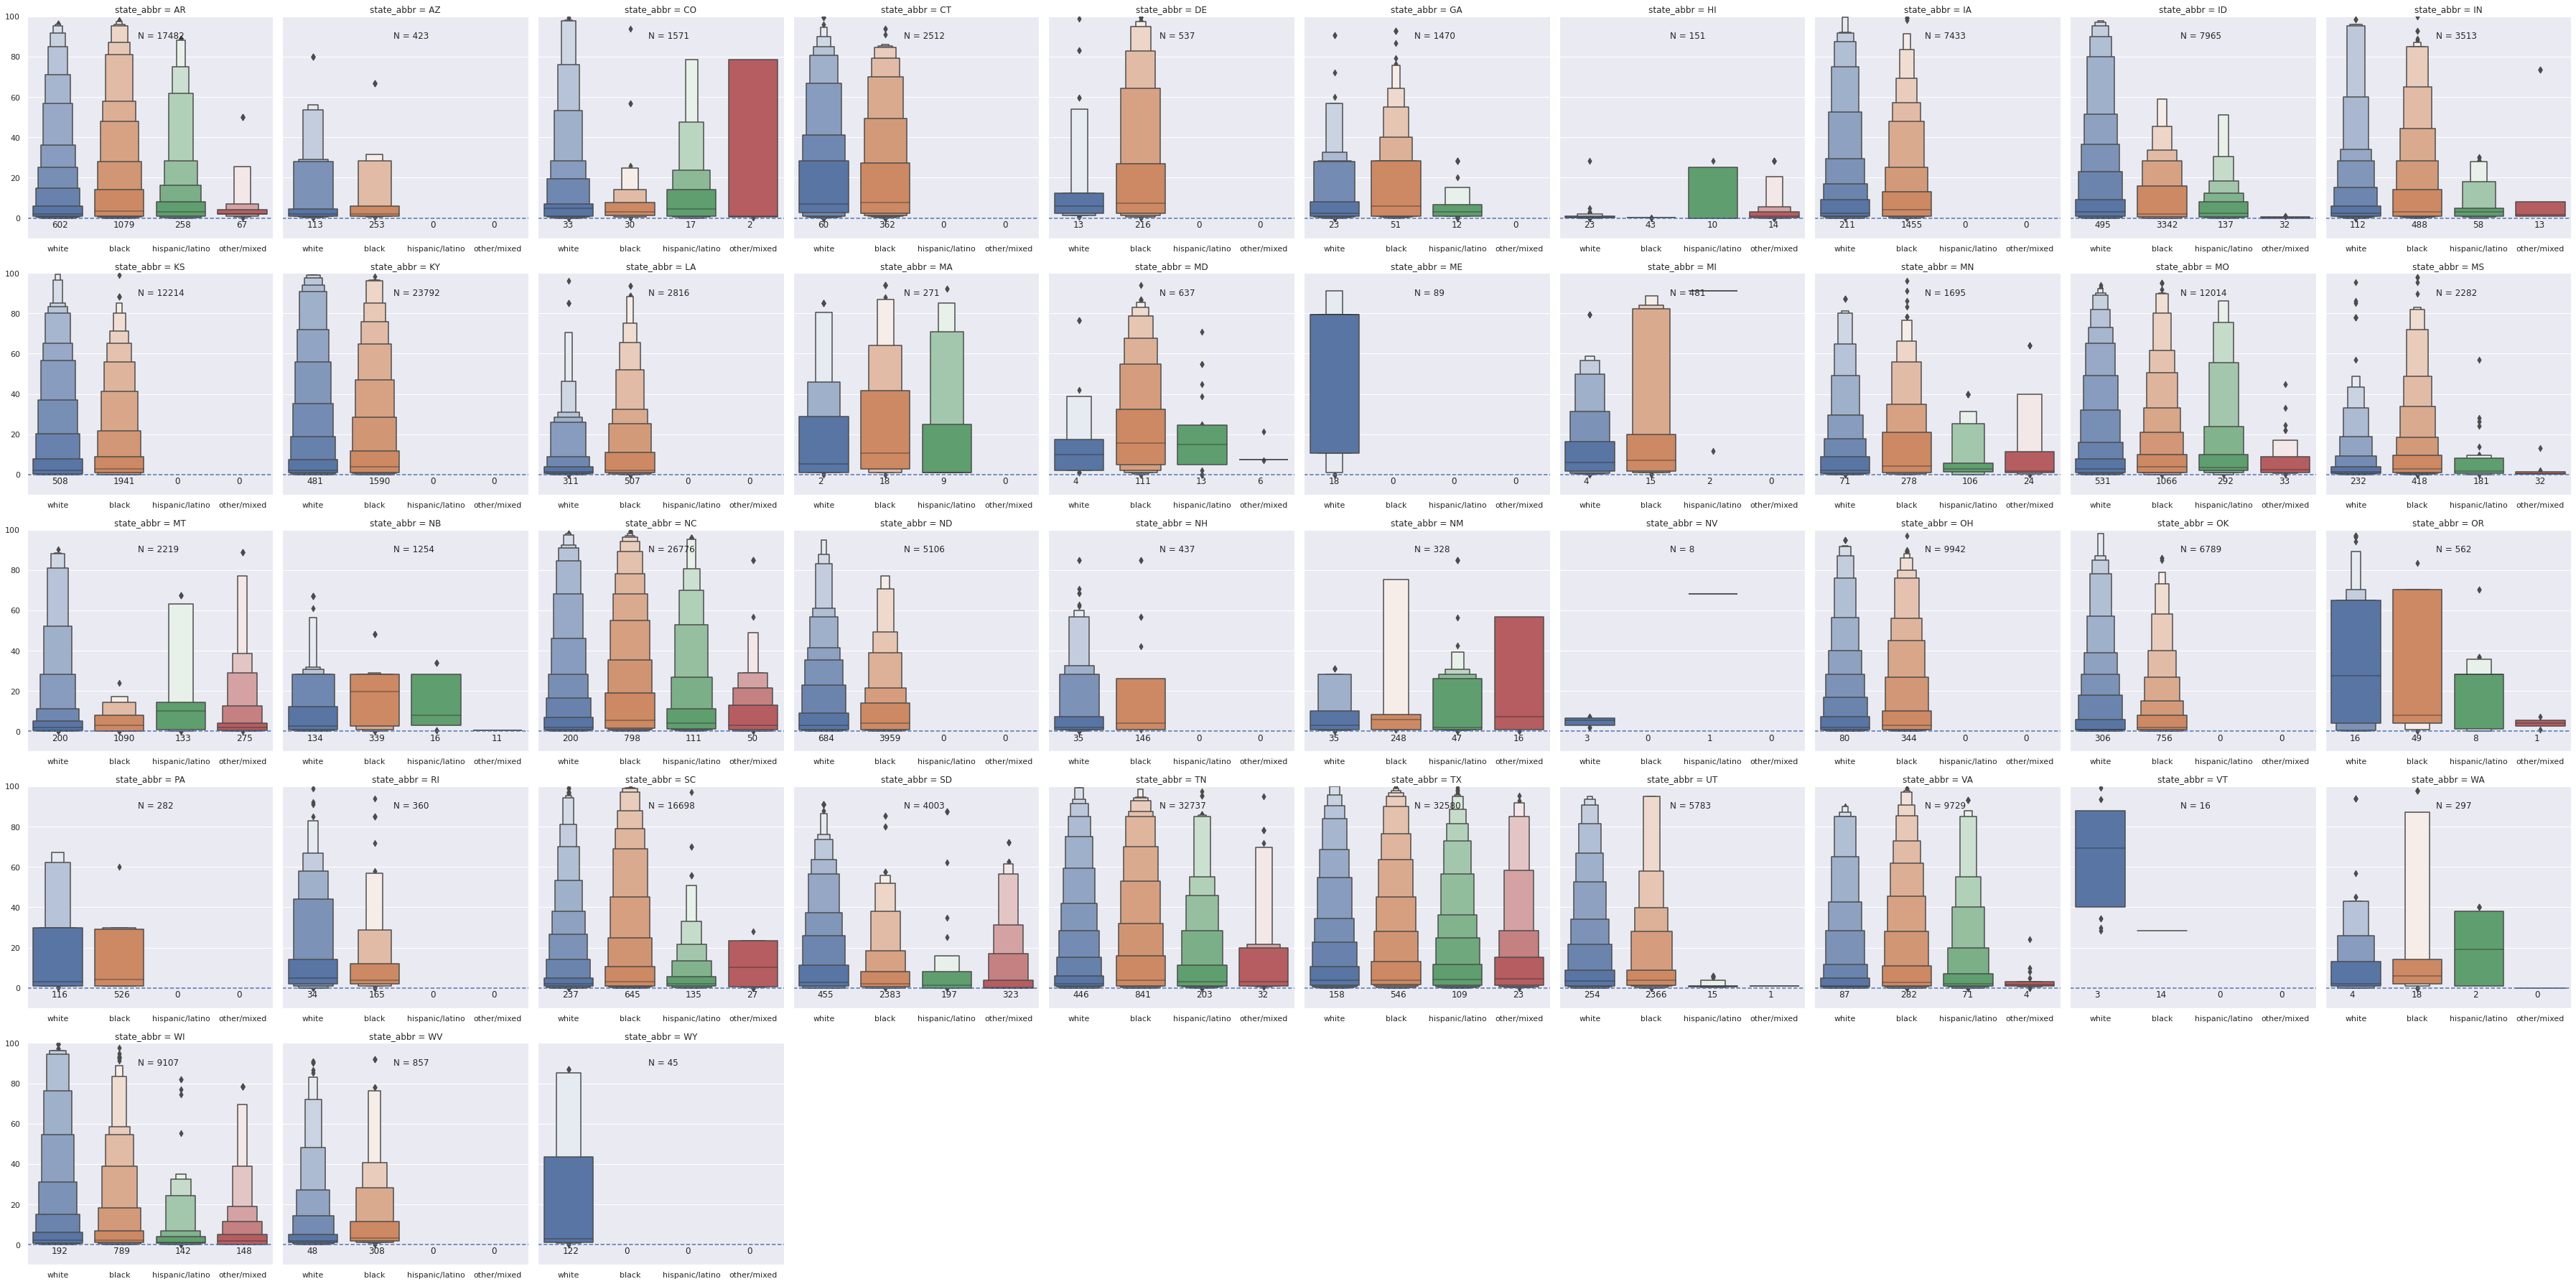

In [48]:
def boxen_plot(dataframe: pd.DataFrame, per_100K: bool = True):

    g = sns.catplot(x="dm_offender_race_ethnicity", y='est_drug_qty_standard',
                       col='state_abbr', col_order=states, data=dataframe, col_wrap=10, sharex=False, kind="boxen", scale="linear", order=races)
    
    def annotate(data, **kws):
        n = len(data)
        ax = plt.gca()
        ax.text(.45, 0.9, f"N = {n}", transform=ax.transAxes)
        state = data["state_abbr"].iloc[0]
        for i, race in enumerate(races):
            n_race = len(data[data["dm_offender_race_ethnicity"] == race])
            if per_100K:
                adjustment_coef =  joined_df[(joined_df["Location"] == state)][race].values[0]
            else:
                adjustment_coef = 1
            ax.text(.1 + (i * .25), 0.05, f"{n_race * adjustment_coef:.0f}", transform=ax.transAxes)
    

    for ax in g.axes:
        ax.axhline(0, ls='--')
        ax.set_ylim([-10, 100])
        
    g.map_dataframe(annotate)
        
boxen_plot(cannabis_df)

### State by state Cannabis Boxen Plot U21

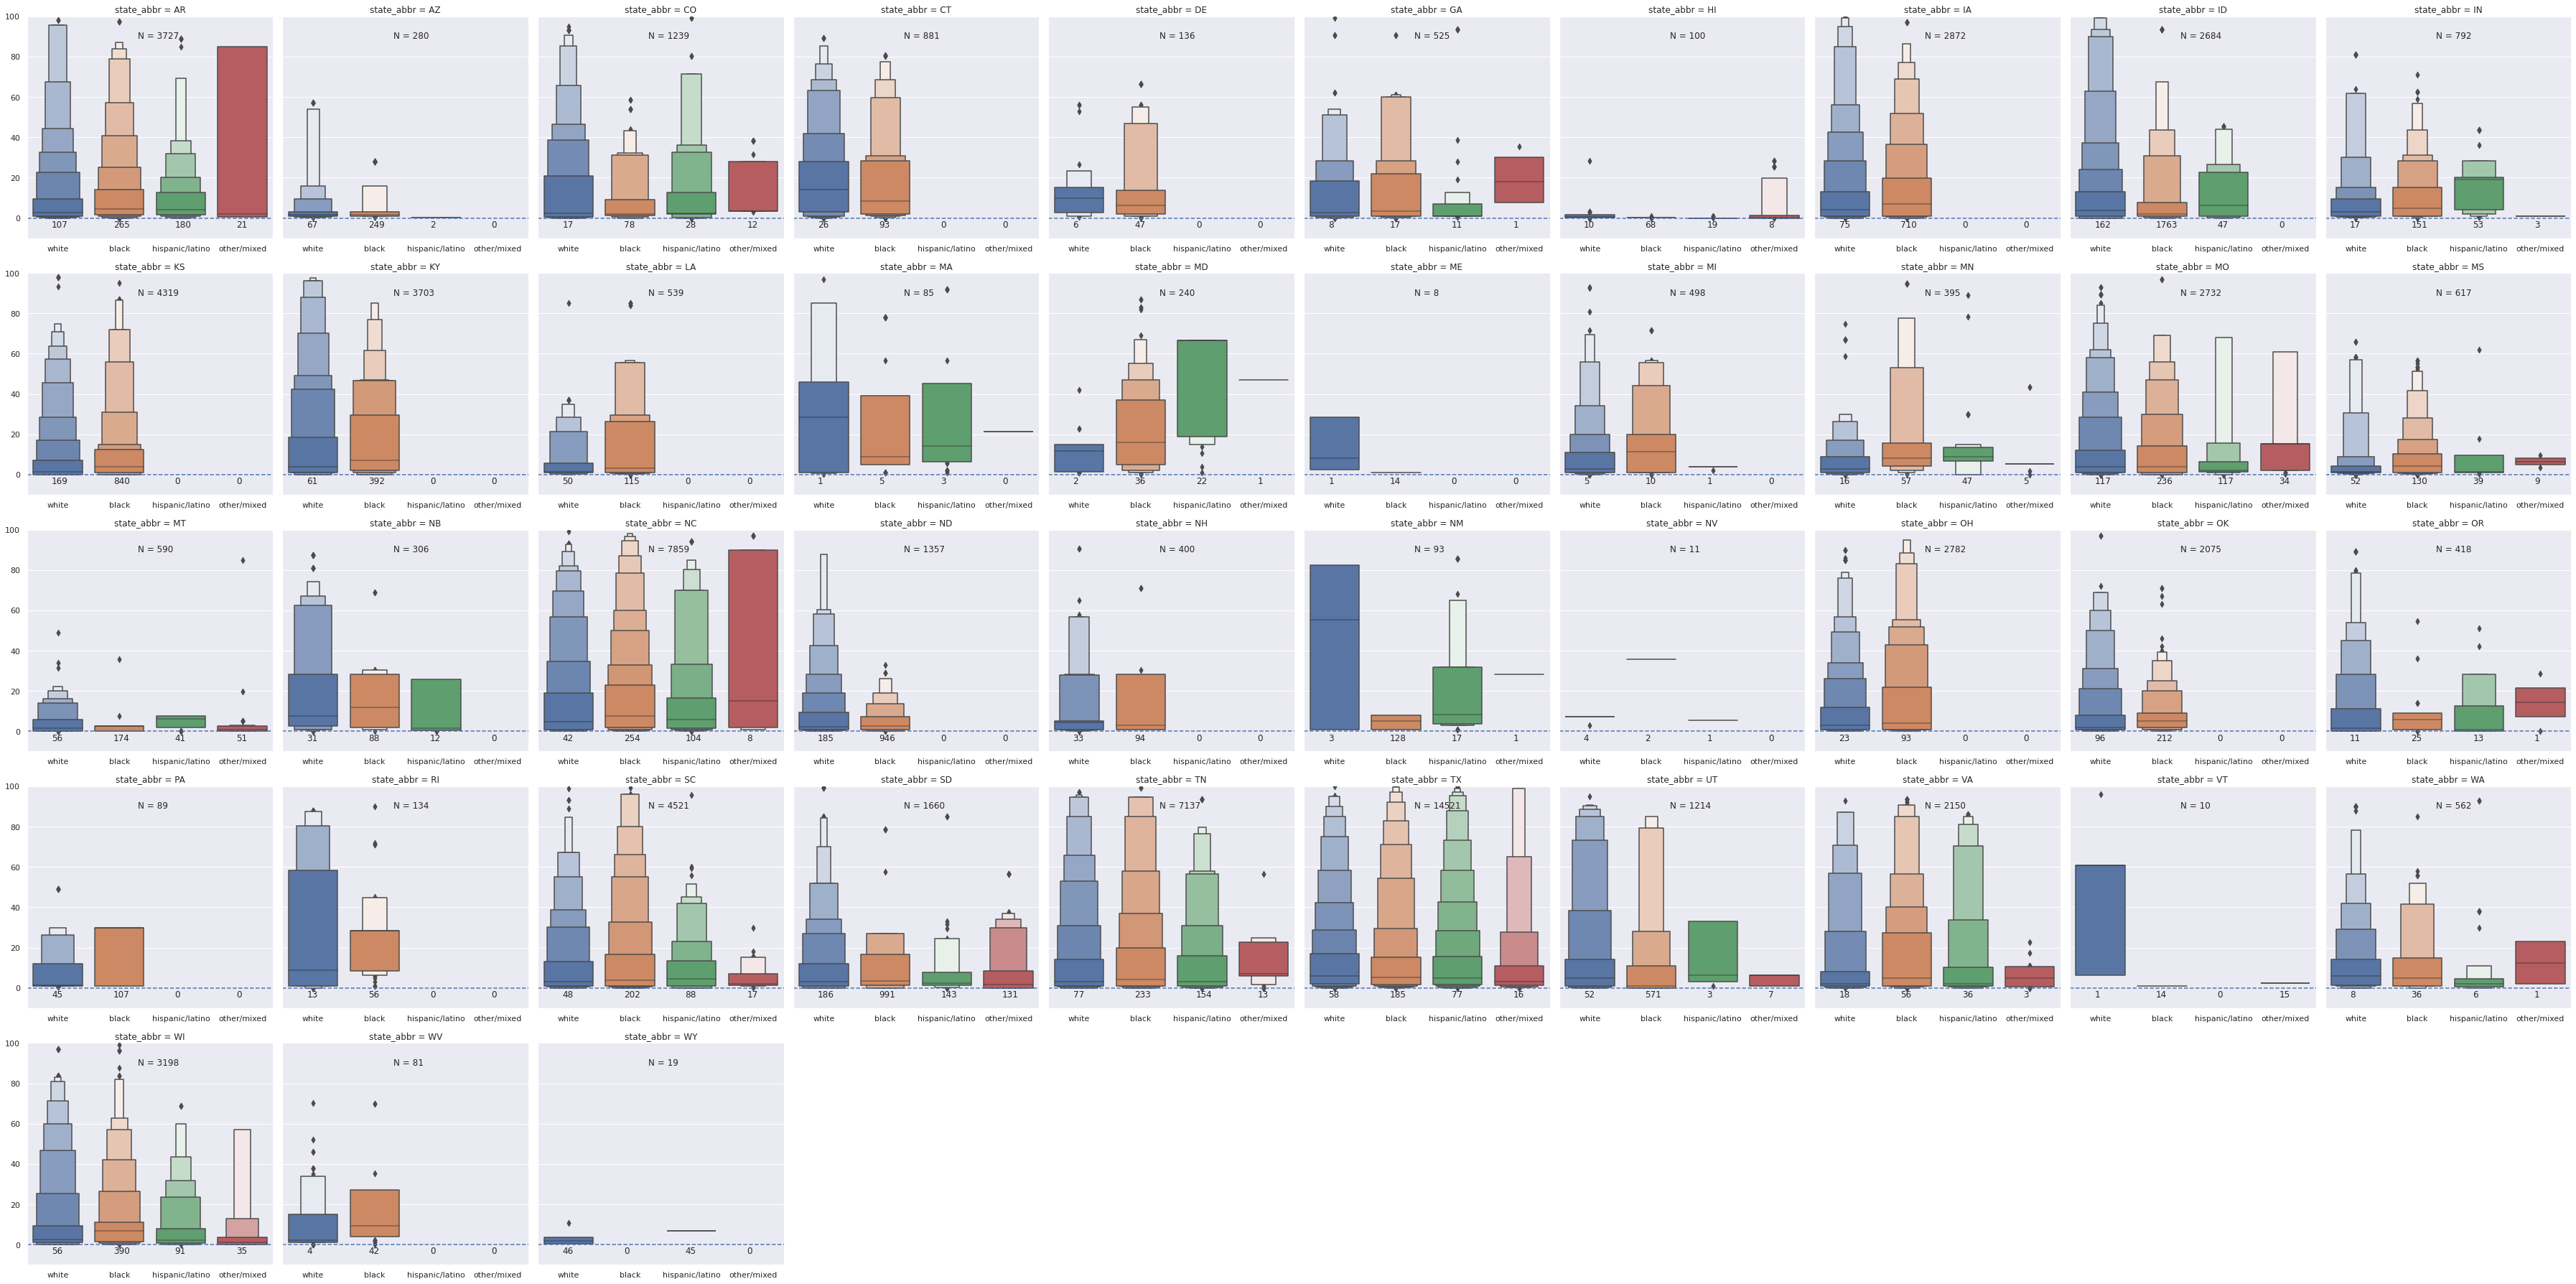

In [49]:
boxen_plot(cannabis_df_U21)

## Black/White Arrest Ratio Map

In [63]:
import plotly.graph_objects as go

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

ratio_list = list()

for state in states:
    state_df = cannabis_df[cannabis_df["state_abbr"] == state]
    n_white = len(state_df[state_df["dm_offender_race_ethnicity"] == "white"])
    white_coef =  joined_df[(joined_df["Location"] == state)]["white"].values[0]
    white_adjusted = n_white * white_coef
    
    n_black = len(state_df[state_df["dm_offender_race_ethnicity"] == "black"])
    black_coef =  joined_df[(joined_df["Location"] == state)]["black"].values[0]
    black_adjusted = n_black * black_coef
    
    
    n_hispanic = len(state_df[state_df["dm_offender_race_ethnicity"] == "hispanic/latino"])
    hispanic_coef =  joined_df[(joined_df["Location"] == state)]["hispanic/latino"].values[0]
    hispanic_adjusted = n_hispanic * hispanic_coef
    
    n_mixed = len(state_df[state_df["dm_offender_race_ethnicity"] == "other/mixed"])
    mixed_coef =  joined_df[(joined_df["Location"] == state)]["other/mixed"].values[0]
    mixed_adjusted = n_mixed * mixed_coef

    ratio = black_adjusted / white_adjusted

    ratio_list.append([state, f"{ratio:.2f}", f"{white_adjusted:.0f}", f"{black_adjusted:.0f}", f"{hispanic_adjusted:.0f}", f"{mixed_adjusted:.0f}", len(state_df)])
    
ratio_df = pd.DataFrame(ratio_list, columns=["State", "ratio", "White_100K", "Black_100K", "Hispanic_100K", "Mixed_100K", "N"])
    
for col in ratio_df.columns:
    ratio_df[col] = ratio_df[col].astype(str)
    
ratio_df['text'] = ratio_df['State'] + '<br>' + \
    'Black/White Ratio: ' + ratio_df['ratio'] + '<br>' + \
    'Black 100K:' + ratio_df['Black_100K'] + '<br>' + \
    'White 100K: ' + ratio_df['White_100K'] + '<br>' + \
    'Hispanic/Latino 100K: ' + ratio_df['Hispanic_100K'] + '<br>' + \
    'Mixed/Other 100K: ' + ratio_df['Mixed_100K'] + '<br>' + \
    'Samples: ' + ratio_df['N']



fig = go.Figure(data=go.Choropleth(
    locations=ratio_df['State'], 
    z = ratio_df['ratio'].astype(float), 
    locationmode = 'USA-states', 
    colorscale = 'Reds',
    text=ratio_df['text'],
    hoverinfo="text",
    colorbar_title = "Ratio Black/White Arrests per 100K",
))

fig.update_layout(
    title_text = '',
    geo_scope='usa',
)

fig.show()

fig.write_html("map.html")